In [22]:
%run ../../main.py
%matplotlib inline

In [23]:
import pandas as pd
import fim
import random

from itertools import chain

from cba.algorithms import generateCARs, apriori, top_rules
from cba.data_structures import TransactionDB, Item, Consequent, Antecedent

In [24]:
#
# =================================
# CBARuleGenerator
# =================================
#

class ComparableSetItem:
    
    def issuperset(self, other):
        return frozenset(self) >= frozenset(other)
        
    def issubset(self, other):
        return frozenset(self) <= frozenset(other) 
        
    def __ge__(self, other):
        return self.issuperset(other)
        
    def __le__(self, other):
        return self.issubset(other)

class AssociationRule:
    
    rule_id = 0
    
    def __init__(self, antecedent, consequent, support=0, confidence=0):
        self.id = AssociationRule.rule_id
        AssociationRule.rule_id += 1
        
        self.antecedent = antecedent
        self.consequent = consequent
        self.support = support
        self.confidence = confidence
        
    def _get_tuple(self):
        """
        returns: (antecedent, consequent) attribute-value pair
        """
        return (self.antecedent, self.consequent)
    
    def __hash__(self):
        return hash(self._get_tuple())
    
    def __eq__(self, other):
        return hash(self) == hash(other)
    
    def __repr__(self):
        args = [self.antecedent, self.consequent, self.support, self.confidence, self.id]
        text = "Association Rule {0} -> {1} | support: {2:.2f} %, confidence: {} %, id: {4}".format(*args)
        return text
    
    
    
    
class RuleSupCounter:
    
    def __init__(self, class_labels):
        unique_class_items = list(set(class_labels))
        convert_item_to_pair = lambda item: (item[1], 0)
        
        
        self.class_dict = dict(map(convert_item_to_pair, unique_class_items))
        pass
    
    def __getitem__(self, idx):
        return self.class_dict.get(idx, None)
    
    def __setitem__(self, idx, val):
        self.class_dict[idx] = val
    
    def __repr__(self):
        return repr(self.class_dict)
    
    def __hash__(self):
        return hash(self.class_dict)
    
    def most_supported(self):
        """
        choose most supported class
        """
        values = self.class_dict.values()
        
        max_val = max(values)
        
        max_classes = {}
        
        for class_name, class_val in self.class_dict.items():
            if class_val == max_val:
                max_classes[class_name] = class_val
        
        length = len(max_classes)
        
        # if there is more than one class with max count
        # choose randomly between them
        if length > 1:
            choice = random.randint(0, length - 1)
            
            # convert to a list a then choose a random tuple
            max_classes = list(max_classes.items())[choice]
        else:
            max_classes = list(max_classes.items())[0]
        
        return max_classes


    
class RuleCandidate(AssociationRule):
    def __init__(self, antecedent, possible_classes, support = 0, confidence = 0, rule_id = 0):
        self.antecedent = antecedent
        self.condsup_count = 0
        self.rulesup_counter = RuleSupCounter(possible_classes)
        self.consequent = None
        self.rulesup_count = 0
        self.support = support
        self.confidence = confidence
        self.id = AssociationRule.rule_id
        AssociationRule.rule_id += 1
        
        
    def max_class(self):
        """
        choose class that has the most support
        """
        class_val, counter = self.rulesup_counter.most_supported()
        
        self.consequent = Consequent("Class", class_val)
        self.rulesup_count = counter
        
    def get_consequent(self):
        self.max_class();
        return self.consequent
        
    def satisfies(self, minsup, minconf, dataset_len):
        """
        test if candidate satisfies given minconf and minsup
        """
        
        rulesup_count = self.rulesup_count
        
        self.confidence = 0 if self.condsup_count == 0 else rulesup_count / self.condsup_count * 100
        self.support = rulesup_count / dataset_len * 100
        
        if self.confidence >= minconf and self.support >= minsup:
            return True
        else:
            return False
        
    def __repr__(self):
        return "Rule Candidate: {0} | rulesupCounter: {1} | condsupCount: {2}".format(self.antecedent, self.rulesup_counter, self.condsup_count)
    
    
    

class ClassAssocationRule(RuleCandidate):
    def __init__(self, antecedent, consequent, support, confidence, id_rule):
        self.antecedent = antecedent
        self.consequent = consequent
        self.support = support
        self.confidence = confidence
        self.id = id_rule
        
        self.marked = False
        
        self.error_number = 0
    
    def __gt__(self, other):
        """
        precedence operator
        """
        if (self.confidence > other.confidence):
            return True
        elif (self.confidence == other.confidence and
              self.support > other.support):
            return True
        elif (self.confidence == other.confidence and
              self.support > other.support and
              self.rule_id < other.rule_id):
            return True
        else:
            return False
    
    def __lt__(self, other):
        """
        rule precedence operator
        """
        return not self > other
    
    def __len__(self):
        return len(self.antecedent) + len(self.consequent)
    
    
    def mark(self):
        self.marked = True
        
    def is_marked(self):
        return self.marked
    
    def test_datacase(self, datacase, y):
        condset_test = self.antecedent <= datacase
        y_test = y == self.consequent.getclass()
        return condset_test and y_test
    
    @staticmethod
    def from_association_rule(rule):
        args = rule.antecedent, rule.consequent, rule.support, rule.confidence, rule.id
        
        return ClassAssocationRule(*args)
    
    # duplicity !
    def __repr__(self):
        args = [self.antecedent, self.consequent, self.support, self.confidence, self.id]
        text = "CAR {0} -> {1} | support: {2:.2f} %, confidence: {3:.2f} %, id: {4}".format(*args)
        return text
        
        
        
        
class DataCase(ComparableSetItem):
    """
    data structure for representing
    a single row in a dataset
    """
    
    def __init__(self, row, header, class_item):
        self.class_val = class_item
        self.items = []
        self.hidden = False
        for idx, val in enumerate(row):
            header_label = header[idx]
            item = Item(header_label, val)
            self.items.append(item)
            
    def __repr__(self):
        return "\nDataCase: {0}".format(self.items)
    
    def __hash__(self):
        return hash(tuple(self.items))
    
    def __getitem__(self, idx):
        return self.items[idx]
    
    def getclass(self):
        return self.class_val
    
    
    
    
class DataSet:
    """
    data structure for mapping a [[primitive]] to [[Item]]
    
    
    todo: lazy processing
    """
    
    def __init__(self, dataset, header):
        """
        arguments:
        - dataset: [[primitive]]
        - header: [string] - feature labels
        
        assert:
        - len(header) == len(values_list)
        
        """
        
        self.class_labels = []
        
        new_dataset = []

        for row in dataset:
            class_label = Item(header[-1], row[-1])
            new_row = DataCase(row[:-1], header[:-1], class_label)
            
            self.class_labels.append(class_label)
            
            new_dataset.append(new_row)
            
        self.data = new_dataset
        self.classes = list(map(lambda i: i[1], self.class_labels))
        
        
    def to_frozenset(self):
        return list(map(frozenset, self.data))
    
    def flatten(self):
        return chain(*self.data)
    
    def unique_items(self):
        return set(self.flatten())
    
    def unique_labels(self):
        return set(self.class_labels)
    
    def show_all():
        for d in self:
            d.hidden = True
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def labels_copy(self):
        return copy(self.class_labels)
    
    def data_copy(self):
        return copy(self.data)
    
    def count_support(self, cedents):
        """
        counts support of an item
        """
        count = 0
        
        for datacase in self.data:
            for cedent in cedents:
                if cedent <= datacase:
                    cedent.supcount += 1
                    cedent.possible_classes.update([datacase.class_val]) 
                    
                
                
            
    
    @staticmethod
    def from_pandasdf(df):
        """
        convert pandas dataframe to DataSet
        """
        
        rows = df.values
        header = list(df.columns.values)

        return DataSet(rows, header)

    
    def __repr__(self):
        return "Dataset:\n______\n{0}\n\nClass labels: {1}".format(self.data, self.class_labels)
        
    def __len__(self):
        return len(self.data)

        

class CBARuleGenerator:
    
    def __init__(self, dataset, minsup, minconf, max_combinations=1000000):
        self.dataset = dataset
        self.minsup = minsup * 100
        self.minconf = minconf * 100
        self.max_combinations = max_combinations
        
        
    
    def generate_k_length_items(self, baseitems, k):
        """
        generates combinations of k-length items
        
        baseitems: items from which to generate
        """
        
        items_combinations = []
        
        if k > 1:
            # outputs a generator
            # ((item)) - combinations are in tuples
            #items_combinations = map(list, combinations(baseitems, k))
            
            items = [baseitems[start:end + 1]
             for start in range(len(baseitems)) 
             for end in range(start, len(baseitems))
             if len(list(chain(*baseitems[start:end + 1]))) == k
            ]

            items_combinations = [list(chain(*r)) for r in items]
            
            
        else:
            # convert each item to [item]
            items_combinations = map(lambda item: [item], baseitems)
            
        # convert tuples to candidate ruleitems 
        candidate_ruleitems = []
        
        unique_combinations = set()
        for idx, itemset in enumerate(items_combinations):
            candidate = RuleCandidate(Antecedent(itemset), self.dataset.class_labels)
            
            if len(candidate.antecedent) == k and candidate not in unique_combinations:
                candidate_ruleitems.append(candidate)
                unique_combinations.add(candidate)
            
        return list(unique_combinations)
    
    
    def count_supports(self, candidate_rules):
        """
        counts rulesupcount and condsupcount for each candidate
        """
        
        for datacase in self.dataset:
            rulesubset = self.rulesubset(datacase, candidate_rules)
            
            for rule in rulesubset:
                rule.condsup_count += 1
                class_name, class_val = datacase.getclass()
                
                rule.rulesup_counter[class_val] += 1
                
        return candidate_rules
    
    
    def filter_rules(self, candidate_rules):
        """
        filter candidate rules based on minimal support and confidence
        """
        filtered_rules = []
        
        for rule in candidate_rules:
            rule.get_consequent()
            if rule.satisfies(self.minsup, self.minconf, len(self.dataset)):
                filtered_rules.append(rule)
                
        return filtered_rules
            
            
    def generate_frequent_items(self, k, items):
        candidate_rules = self.generate_k_length_items(items, k)
        
        self.count_supports(candidate_rules)
        
        filtered_rules = self.filter_rules(candidate_rules)
        
        return filtered_rules
        
        
        
    def rulesubset(self, datacase, candidate_rules):
        """
        return all the candidate_rules that are supported by datacase
        """
        new_rules = []
        
        for rule in candidate_rules:
            if rule.antecedent <= datacase:
                new_rules.append(rule)
        
        return new_rules
        
        
    def get_items(self, frequent_rules):
        """
        gets single items from frequent rules
        """
        return list(map(lambda r: r.antecedent, frequent_rules))
        
    def generate(self):
        candidate_rules = []
        frequent_items = []

        candidate_rules1 = self.generate_frequent_items(1, list(self.dataset.unique_items()))

        items1 = self.get_items(candidate_rules1)

        candidate_rules.append(candidate_rules1)

        for item in items1:
            i = list(map(lambda i: Item(*i), item))
            frequent_items.append(i)
        
        k = 0
        
        while candidate_rules[k] and k < self.max_combinations - 1:
            k += 1
            
            candidate_rules_n = self.generate_frequent_items(k + 1, frequent_items)

            items_n = self.get_items(candidate_rules_n)

            candidate_rules.append(candidate_rules_n)
            

            for item in items_n:
                i = list(map(lambda i: Item(*i), item))
                frequent_items.append(i)
        
        
        cars = []
        for rule in chain(*candidate_rules):
            arc = ClassAssocationRule(rule.antecedent, rule.consequent, rule.support, rule.confidence, rule.id)
            cars.append(arc)
    
        return cars
    
    
    

In [25]:
#
#
# =========================
# Oveření běhu v závislosti na vložených pravidlech / instancích
# =========================
#
#
#

import time

benchmark_data = {
    "data_count": [],
    "apriori_duration": []
}

stop_m2 = False

number_of_iterations = 10

dataset_name_benchmark = "lymph0"

pd_ds = pd_ds = pd.read_csv("c:/code/python/machine_learning/assoc_rules/train/{}.csv".format(dataset_name_benchmark))

for i in range(10):
    dataset_name_benchmark = "lymph0"
    
    pd_ds = pd.concat([pd_ds, pd_ds])
    
    txns = TransactionDB.from_pandasdf(pd_ds)
    
    

    apriori_t1 = time.time()
    for _ in range(number_of_iterations):
        rules = fim.apriori(txns.string_representation, supp=20, conf=50, target="r", report="sc", appear=txns.appeardict)
    
    apriori_proctime = (time.time() - apriori_t1) / number_of_iterations
    
    
     
    benchmark_data["data_count"].append(len(txns))
    benchmark_data["apriori_duration"].append(apriori_proctime)

    print("data_count:", len(txns))
    print("apriori_duration:", apriori_proctime)
    print("\n\n")

data_count: 260
apriori_duration: 0.1442025899887085



data_count: 520
apriori_duration: 0.1197852373123169



data_count: 1040
apriori_duration: 0.12639312744140624



data_count: 2080
apriori_duration: 0.13910286426544188



data_count: 4160
apriori_duration: 0.172072172164917



data_count: 8320
apriori_duration: 0.2115550994873047



data_count: 16640
apriori_duration: 0.21690399646759034



data_count: 33280
apriori_duration: 0.3381976127624512



data_count: 66560
apriori_duration: 0.5506564140319824



data_count: 133120
apriori_duration: 1.026135301589966





In [29]:

import time

benchmark_data_2 = {
    "data_count": [],
    "cbarg_naive_duration": []
}

stop_m2 = False

number_of_iterations = 1

dataset_name_benchmark = "lymph0"

pd_ds = pd_ds = pd.read_csv("c:/code/python/machine_learning/assoc_rules/train/{}.csv".format(dataset_name_benchmark))

for i in range(6):
    dataset_name_benchmark = "lymph0"
    
    pd_ds = pd.concat([pd_ds, pd_ds])
    
    txns = DataSet.from_pandasdf(pd_ds)
    
    

    apriori_t1 = time.time()
    for _ in range(number_of_iterations):
        print(_)
        cbarg = CBARuleGenerator(txns, 0.2, 0.5)
        rules = cbarg.generate()
        
    apriori_proctime = (time.time() - apriori_t1) / number_of_iterations
    
    
     
    benchmark_data_2["data_count"].append(len(txns))
    benchmark_data_2["cbarg_naive_duration"].append(apriori_proctime)

    print("data_count:", len(txns))
    print("cbarg_naive_duration:", apriori_proctime)
    print("\n\n")




0
data_count: 260
cbarg_naive_duration: 1.2363791465759277



0
data_count: 520
cbarg_naive_duration: 2.1960573196411133



0
data_count: 1040
cbarg_naive_duration: 4.883049011230469



0
data_count: 2080
cbarg_naive_duration: 8.676722049713135



0
data_count: 4160
cbarg_naive_duration: 19.63909649848938



0
data_count: 8320
cbarg_naive_duration: 37.40285134315491





In [30]:
naive_dur = benchmark_data_2["cbarg_naive_duration"]

benchmark_data["cbarg_naive_duration"] = naive_dur + [None] * (len(benchmark_data["apriori_duration"]) - len(naive_dur))

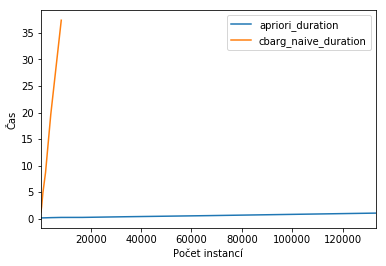

In [32]:
benchmark_df = pd.DataFrame(benchmark_data)


ax = benchmark_df.plot(x=["data_count"], y=["apriori_duration", "cbarg_naive_duration"])
ax.set_xlabel("Počet instancí")
ax.set_ylabel("Čas")

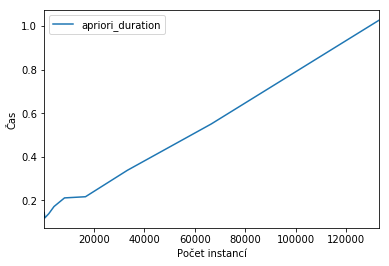

In [33]:
ax = benchmark_df.plot(x=["data_count"], y=["apriori_duration"])
ax.set_xlabel("Počet instancí")
ax.set_ylabel("Čas")

In [38]:
cl